In [1]:
from libraries import * # Import libraries from libraries.py
from import_data import * # Import data from import_data.py
from global_variables import * # Import global variables from global_variables.py
from plotting_functions import * # Import plotting functions from plotting_functions.py

# Read in output data from cleaning script. Set date to datetime dtype
df_joined_cases = pd.read_csv(os.getcwd().split('API-201Z')[0] + 'API-201Z/Data Sources/cleaned_joined_states.csv')
df_joined_cases['date'] = pd.to_datetime(df_joined_cases['date'])

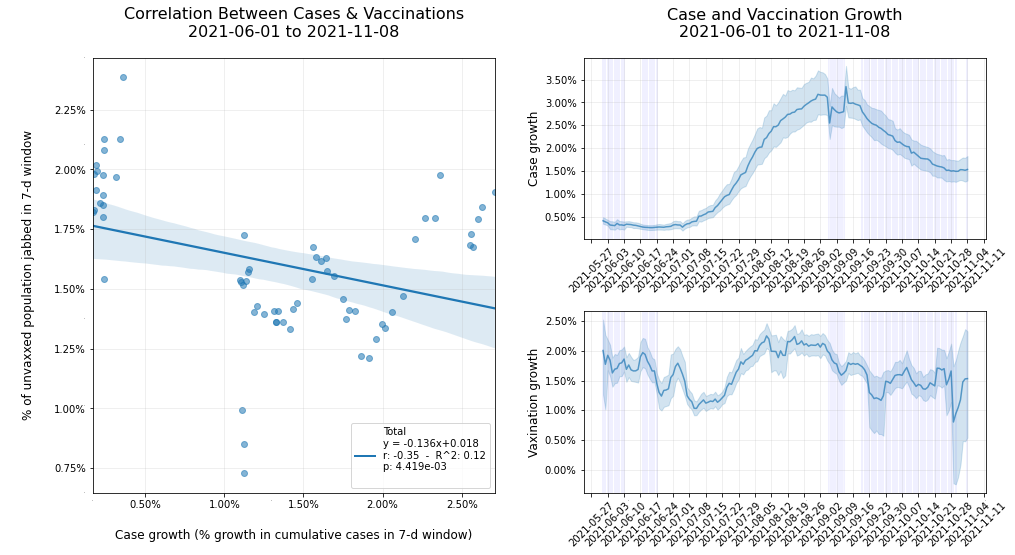

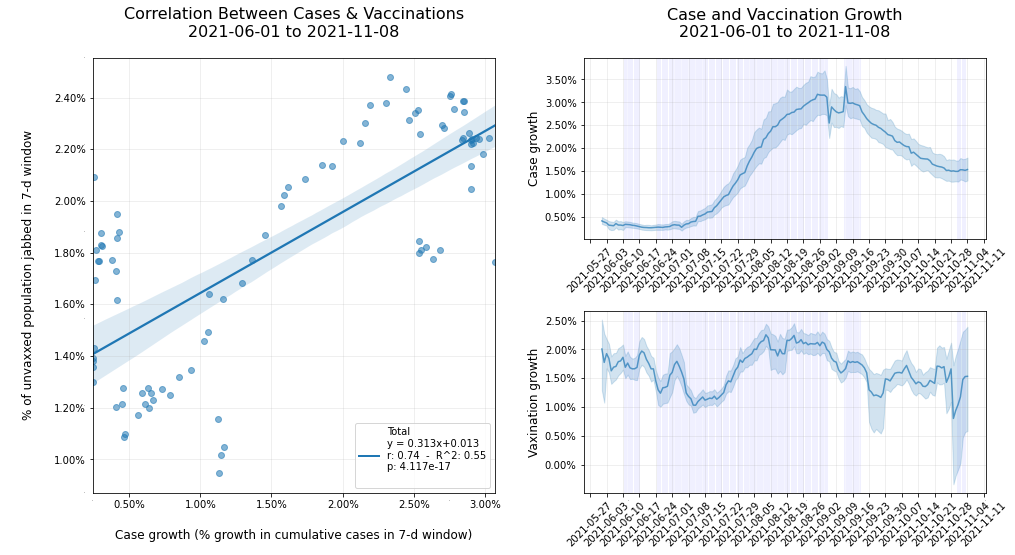

In [2]:
# Make increasing and decreasing flag in agg tables, then filter plots by increasing or decreasing
def vax_cases_and_correlation_inc_dec(data, groupby, hue_levels, inc_dec, start=START_DATE, end=END_DATE):
    
    fig, ax = plt.subplots(figsize=(16,8))

    sub1 = fig.add_subplot(2,2,2) # two rows, two columns, 2nd cell
    sub2 = fig.add_subplot(2,2,4) # two rows, two columns, 4th cell
    sub3 = fig.add_subplot(2,2,(1,3)) # two rows, two colums, combined first and third cell

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.subplots_adjust(wspace=0.22, hspace=0.4)
    

    # Create aggregation and lm plot function        
    def agg_reg(data, groupby, hue_levels, inc_dec, ax, start=START_DATE, end=END_DATE, line_kws=None, legend=False):    
        
        # If there's no groupby argument, only aggregate by date. Re-calculate WoW fields and cut to time window
        if groupby == None:
            agg = data.groupby('date')[['cases', 'unvaxxed']].sum().reset_index()
            agg['WoW_%_cases'] = (agg['cases'] - agg['cases'].shift(7)) / agg['cases'].shift(7)
            agg['WoW_%_vax'] = (agg['unvaxxed'].shift(7) - agg['unvaxxed'] ) / agg['unvaxxed'].shift(7)
            agg['case_diff_WoW'] = (agg['cases'] - agg['cases'].shift(7)) - (agg['cases'].shift(7) - agg['cases'].shift(14))
            agg['inc_or_dec'] = ['Increasing' if diff >= 0 else 'Decreasing' for diff in agg['case_diff_WoW']]
            agg = agg.query('@start <= date <= @end & inc_or_dec == @inc_dec')
            line_kws = {'label':"Linear Reg"}
            legend=True
        else: # Otherwise group by groupby and re-calculate WoW fields and cut to time window         
            agg = data.groupby(['date', groupby])[['cases', 'unvaxxed']].sum().reset_index()
            agg['WoW_%_cases'] = (agg['cases'] - agg.groupby([groupby])['cases'].shift(7)) / agg.groupby([groupby])['cases'].shift(7)
            agg['WoW_%_vax'] = (agg.groupby([groupby])['unvaxxed'].shift(7) - agg['unvaxxed'] ) / agg.groupby([groupby])['unvaxxed'].shift(7)
            agg['case_diff_WoW'] = (agg.groupby([groupby])['cases'].shift(0) - agg.groupby([groupby])['cases'].shift(7)) - (agg.groupby([groupby])['cases'].shift(7) - agg.groupby([groupby])['cases'].shift(14))
            agg['inc_or_dec'] = ['Increasing' if diff >= 0 else 'Decreasing' for diff in agg['case_diff_WoW']]
            agg = agg.query('@start <= date <= @end & inc_or_dec == @inc_dec')
            
        # Iterate through levels of hue_levels, run linear regression, store results in stats_results
        stats_results = []
        if groupby != None:
            for i in range(len(hue_levels.keys())):
                level = list(hue_levels.keys())[i]                                           
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    agg[(agg[groupby] == level) & (agg['date'] >= start) & (agg['date'] < end)]['WoW_%_cases'],
                    agg[(agg[groupby] == level) & (agg['date'] >= start) & (agg['date'] < end)]['WoW_%_vax']
                    )
                stats_results.append((slope, intercept, r_value, p_value, std_err))
        else: # If groupby argument is empty just run the regression once
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                agg[(agg['date'] >= start) & (agg['date'] < end)]['WoW_%_cases'],
                agg[(agg['date'] >= start) & (agg['date'] < end)]['WoW_%_vax']
                )       
            stats_results.append((slope, intercept, r_value, p_value, std_err))
        
        if groupby != None:
            for level in agg[groupby].unique():
                # Set up plot
                g = sns.regplot(
                    data=agg[agg[groupby] == level].query('inc_or_dec == @inc_dec'), 
                    x='WoW_%_cases', 
                    y='WoW_%_vax', 
                    robust=False,                    
                    color=hue_levels[level],
                    scatter_kws={"alpha": 0.55},
                    ax=ax 
                    )
        else:
            # Set up plot
            g = sns.regplot(
                data=agg.query('inc_or_dec == @inc_dec'), 
                x='WoW_%_cases', 
                y='WoW_%_vax',                 
                robust=False,                    
                color=list(hue_levels.values())[0],
                scatter_kws={"alpha": 0.55},
                line_kws=line_kws,
                ax=ax 
                )
                

        legend_labels = []
        for j in range(len(stats_results)):
            level = list(hue_levels.keys())[j]
            mxb = r'y = {0:.3f}x+{1:.3f}'.format(stats_results[j][0], stats_results[j][1])
            r = 'r: ' + '{:0.2}'.format(stats_results[j][2]) + '  -  R^2: ' + '{:0.2}'.format(stats_results[j][2]**2)
            p = 'p: ' + '{:0.3e}'.format(stats_results[j][3])
            legend_labels.append(level + '\n' + mxb + '\n' + r + '\n' + p + '\n')
        
        ax.grid(True, which='both', axis='both', alpha=0.25)   
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))   
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))     
        plt.xlabel('\nCase growth (% growth in cumulative cases in 7-d window)', fontsize=12)
        plt.ylabel('\n% of unvaxxed population jabbed in 7-d window\n', fontsize=12)
        plt.title('Correlation Between Cases & Vaccinations\n' + start + ' to ' + end, fontsize=16, y=1.035)
        
        return g, legend_labels, agg

    
    ar = agg_reg(data=data, groupby=groupby, hue_levels=hue_levels, inc_dec=inc_dec, start=start, end=end, ax=sub3)
    ar

    case_and_vax_plot(
        data= data, # agg_reg(data=data, groupby=groupby, hue_levels=hue_levels, inc_dec=inc_dec, start=start, end=end, ax=sub3)[2], 
        hue_col=groupby, 
        hue_levels=hue_levels, 
        title='Case and Vaccination Growth\n' + start + ' to ' + end,
        start=start, 
        end=end,
        axs=(sub1, sub2)
    )
    
    for d in ar[2].query('inc_or_dec == @inc_dec')['date'].unique():

        sub1.axvspan(
            pd.to_datetime(d), 
            pd.to_datetime(d) - timedelta(days=0.5), 
            alpha=0.04, 
            color='blue', 
            zorder=0
        )
        sub2.axvspan(
            pd.to_datetime(d), 
            pd.to_datetime(d) - timedelta(days=0.5), 
            alpha=0.04, 
            color='blue', 
            zorder=0
        )

    # Create custom legend
    custom_legend = []
    for k, v in hue_levels.items():
        custom_legend.append(Line2D([0], [0], color=v, lw=2))
    
    sub3.legend(custom_legend, ar[1], loc=4, frameon=True)

    # sub3.legend(        
    #     ar[1],               
    #     loc=4, 
    #     # loc='upper left', 
    #     frameon=True
    # )
        
    plt.setp(ax.get_xticklabels(), fontsize=0)
    plt.setp(ax.get_yticklabels(), fontsize=0)
    plt.setp(ax.xaxis.get_ticklines(), 'markersize', 0)
    plt.setp(ax.yaxis.get_ticklines(), 'markersize', 0)
    # plt.tight_layout()

vax_cases_and_correlation_inc_dec(
    data=df_joined_cases, 
    groupby=None, 
    hue_levels={'Total':'tab:blue'},
    inc_dec='Decreasing',
    start="2021-06-01", 
    end="2021-11-08"    
) 
vax_cases_and_correlation_inc_dec(
    data=df_joined_cases, 
    groupby=None, 
    hue_levels={'Total':'tab:blue'},
    inc_dec='Increasing',
    start="2021-06-01", 
    end="2021-11-08"    
) 